In [2]:
import sys
import torch
import torchvision
sys.path.append('/home/charon/project')
from shallowmind.api.infer import prepare_inference
import matplotlib.pyplot as plt

/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
cfg = '/home/charon/project/shallowmind/work_dir/model=gan-dataset=mnist-lr=1e-5/gan_image_cifar_example.py'
ckpt = '/home/charon/project/shallowmind/work_dir/model=gan-dataset=mnist-lr=1e-5/ckpts/exp_name=model=gan-dataset=mnist-lr=1e-5-cfg=gan_image_cifar_example-bs=128-seed=42-step=96614.0000.ckpt'
di, mi = prepare_inference(cfg, ckpt)

In [9]:
pic = mi(torch.ones(3))

In [10]:
di.train_dataloader().dataset[0][0]['image'].min()

tensor(0.)

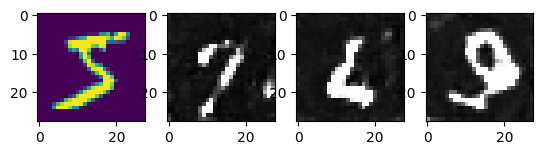

In [11]:
fig, axes = plt.subplots(1, 4)
axes[0].imshow(di.train_dataloader().dataset[0][0]['image'].permute(1, 2, 0))
for i in range(1, 4):
    axes[i].imshow(pic[i-1].permute(1, 2, 0).detach().numpy().sum(axis=-1), cmap='gray')

In [6]:
pic[i].shape

IndexError: index 3 is out of bounds for dimension 0 with size 3

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

input_dim = 100
batch_size = 128
num_epoch = 10


# =================================================生成器================================================================
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32 * 32)
        self.br1 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(32 * 32, 128 * 7 * 7)
        self.br2 = nn.Sequential(
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU()
        )
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.br1(self.fc1(x))
        x = self.br2(self.fc2(x))
        x = x.reshape(-1, 128, 7, 7)
        x = self.conv1(x)
        output = self.conv2(x)
        return output


# =================================================判别器================================================================
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1),
            nn.LeakyReLU(0.2)
        )
        self.pl1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, stride=1),
            nn.LeakyReLU(0.2)
        )
        self.pl2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1024),
            nn.LeakyReLU(0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pl1(x)
        x = self.conv2(x)
        x = self.pl2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        output = self.fc2(x)
        return output

# ==================================================训练================================================================
def training(x):
    '''判别器'''
    real_x = x.to(device)
    real_output = D(real_x)
    real_loss = loss_func(real_output, torch.ones_like(real_output).to(device))

    fake_x = G(torch.randn([batch_size, input_dim]).to(device)).detach()
    fake_output = D(fake_x)
    fake_loss = loss_func(fake_output, torch.zeros_like(fake_output).to(device))

    loss_D = real_loss + fake_loss

    optim_D.zero_grad()
    loss_D.backward()
    optim_D.step()

    '''生成器'''
    fake_x = G(torch.randn([batch_size, input_dim]).to(device))
    fake_output = D(fake_x)
    loss_G = loss_func(fake_output, torch.ones_like(fake_output).to(device))

    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()

    return loss_D, loss_G


if __name__ == '__main__':
    train_dataset = datasets.MNIST(root="./data/", train=True, transform=transforms.ToTensor(), download=False)
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

    G = Generator(input_dim).to(device)
    D = Discriminator().to(device)
    optim_G = torch.optim.Adam(G.parameters(), lr=0.0002)
    optim_D = torch.optim.Adam(D.parameters(), lr=0.0002)
    loss_func = nn.BCELoss()

    for epoch in range(num_epoch):
        total_loss_D, total_loss_G = 0, 0
        for i, (x, _) in enumerate(train_loader):
            loss_D, loss_G = training(x)

            total_loss_D += loss_D
            total_loss_G += loss_G

            if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
                print('Epoch {:02d} | Step {:04d} / {} | Loss_D {:.4f} | Loss_G {:.4f}'.format(epoch, i + 1, len(train_loader), total_loss_D / (i + 1), total_loss_G / (i + 1)))

        x = torch.randn(64, input_dim).to(device)
        img = G(x)

Epoch 00 | Step 0100 / 469 | Loss_D 0.1502 | Loss_G 5.9509
Epoch 00 | Step 0200 / 469 | Loss_D 0.1304 | Loss_G 5.1689
Epoch 00 | Step 0300 / 469 | Loss_D 0.2030 | Loss_G 4.5618
Epoch 00 | Step 0400 / 469 | Loss_D 0.3021 | Loss_G 4.0050
Epoch 00 | Step 0469 / 469 | Loss_D 0.3489 | Loss_G 3.7271
Epoch 01 | Step 0100 / 469 | Loss_D 0.7348 | Loss_G 2.0288
Epoch 01 | Step 0200 / 469 | Loss_D 0.7669 | Loss_G 1.8912
Epoch 01 | Step 0300 / 469 | Loss_D 0.7977 | Loss_G 1.8026
Epoch 01 | Step 0400 / 469 | Loss_D 0.8142 | Loss_G 1.7379
Epoch 01 | Step 0469 / 469 | Loss_D 0.8205 | Loss_G 1.7097
Epoch 02 | Step 0100 / 469 | Loss_D 0.8913 | Loss_G 1.4750
Epoch 02 | Step 0200 / 469 | Loss_D 0.9063 | Loss_G 1.4675
Epoch 02 | Step 0300 / 469 | Loss_D 0.9129 | Loss_G 1.4571
Epoch 02 | Step 0400 / 469 | Loss_D 0.9185 | Loss_G 1.4498
Epoch 02 | Step 0469 / 469 | Loss_D 0.9241 | Loss_G 1.4443
Epoch 03 | Step 0100 / 469 | Loss_D 0.9859 | Loss_G 1.4573
Epoch 03 | Step 0200 / 469 | Loss_D 0.9819 | Loss_G 1.48

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6)
for i in range(6):
    axes[i].imshow(

    .reshape(28, 28), cmap='gray')